# Multi Compartment Model
## Overview

Here we aim to deal with spatially extended neural structures which can't be modelled accurately by a "point neuron". In particular, we use the cable equation to model such extended structures; this equation is usually derived as the space-continuous limit of a spatially discrete model consisting of multiple compartments.

So are going to simulate the time course of the voltage response of the multi compartment model to an input current. 

The multi compartment model has the same parameters as the cable model: a membrane (intracellular) resistance and capacitance $R_m$ and $C_m$, a membrane resting potential $E_m$ (denoted by $E_L$ in the figure), and an axial (intracellular) resistance $R_a$. We use the following parameters for our simulation:
- membrane equilibrium potential: $E_m = 0V$
- Membrane resistance: $R_m = 1.59G\Omega$
- Membrance capacitance: $C_m = 62.8pF$
- Axial resistance: $R_a = 0.0318G\Omega$.

Please note that we follow the naming convention, with capital letters denoting absolute (unnormalized) values.

Further, we want our model to consist of a total of 50 compartments.

### 1.1

**Step 1:** Implement the model parameters

In [9]:
# Import the standard libraries
import numpy as np
import matplotlib.pyplot as plt
# Make plot interactive
%matplotlib inline



E_m = 0
C_m = 62.8 * 10 ** (-12)
R_m = 1.59 * 10 ** 9
R_a = 0.0318 * 10 ** 9

N = 50
t_start = 0
t_stop = 0.6
delta_t = 0.0001

input_compartment = 19
t_e = 0.02
t_s = 0.4
I_0 = 10 ** (-12)
I_1 = 100 * 10 ** (-12)



### 1.2

The differential equation governing the dynamics of the voltage $V(j,t)$ in a given compartment $j$ at time $t$ is given by
$$
C_m \frac{\text{d}}{\text{d}t}V(j,t) = I_e(j,t) + \frac{E_m - V(j,t)}{R_m} + \frac{V(j-1,t) - V(j,t)}{R_a} + \frac{V(j+1,t) - V(j,t)}{R_a},
$$
where $I_e(j,t)$ is the injected current at compartment $j$ and at time $t$.

We can approximate the evolution of the voltage over time using the forward Euler method. Thus, starting at time $t_0 = 0$, we iteratively compute $V(j,t_{n+1}) \approx V(j,t_n) + \Delta t \cdot \frac{\text{d}}{\text{d}t} V(j,t_n)$.
As a first step, we will implement a step of the Euler method for a compartment that does not constitute one of the ends of the model neurite (i.e. the compartment is surrounded by other compartments to either side).

**Step 2:** Completing the function surrounded_compartment_step() in a way that computes a single step of the Euler approximation for a specified compartment. The compartment is assumed to not be at the boundaries.

In [10]:
def surrounded_compartment_step(V, I_e, compartment_index, E_m, C_m, R_m, R_a, delta_t):
    '''Implements a step of the Euler approximation for a non-boundary compartment

    Args:
        V: np.array of length N containing the voltages before taking the Euler step
        I_e: np.array of length N containg the input current before taking the Euler step
        compartment_index: Compartment to be updated in the step
        E_m: Resting potential
        R_m: Membrane resistance
        R_a: Axial resistance
        delta_t: Time constant for the Euler approximation

    Returns:
        np.array of length N containing the voltages after updating compartment compartment_index
    '''
    
    dvdt = I_e / C_m + (E_m - V[compartment_index][-1]) / (R_m * C_m) + (V[compartment_index - 1][-1] - V[compartment_index][-1]) / (R_a * C_m) + (V[compartment_index + 1][-1] - V[compartment_index][-1]) / (R_a * C_m)
    V[compartment_index] = np.append(V[compartment_index], V[compartment_index][-1] + dvdt * delta_t)
    
    return (V)

Since we have a neurite of finite length (split up into 50 compartments), we need to think about what happens on the boundaries. We assume that compartment $0$ is a sealed end, and compartment $49$ is a killed end. A sealed end simply means that there is no voltage gradient at the end of the neurite. In our discrete model, this corresponds to $V(0,t) = V(1,t)$. A killed end means that the voltage is zero, i.e. $V(49,t) = E_m = 0$. Since our function surrounded_compartment_step() doen't implement the boundary conditions, we need to do this seperately.

**Step 3:** Completing the function sealed_compartment_step() s.t. it performs a step of the Euler approximation for a specified compartment. The compartment is a sealed end of the neurite.

In [11]:
### Sealed end on left side of cable
def sealed_compartment_step(V, I_e, E_m, C_m, R_m, R_a, delta_t, compartment_index):
    '''Implements a step of the Euler approximation for a sealed compartment at the spatial origin

    Args:
        V: np.array of length N containing the voltages before taking the Euler step
        I_e: np.array of length N containg the input current before taking the Euler step
        compartment_index: Compartment to be updated in the step
        E_m: Resting potential
        R_m: Membrane resistance
        R_a: Axial resistance
        delta_t: Time constant for the Euler approximation

    Returns:
        np.array of length N containing the voltages after updating compartment compartment_index
    '''

    V[compartment_index] = np.append(V[compartment_index], V[compartment_index + 1][-1])
    return (V)

**Step 4:** Completing the function killed_compartment_step() s.t. it performs a step of the Euler approximation for a specified compartment. The compartment is a killed end of the neurite.

In [12]:
### Killed right end of cable
def killed_compartment_step(V, I_e, E_m, C_m, R_m, R_a, delta_t, compartment_index):
    '''Implements a step of the Euler approximation for a killed compartment at the right end of the cable

    Args:
        V: np.array of length N containing the voltages before taking the Euler step
        I_e: np.array of length N containg the input current before taking the Euler step
        compartment_index: Compartment to be updated in the step
        E_m: Resting potential
        R_m: Membrane resistance
        R_a: Axial resistance
        delta_t: Time constant for the Euler approximation

    Returns:
        np.array of length N containing the voltages after updating compartment compartment_index
    '''
    
    V[compartment_index] = np.append(V[compartment_index], E_m)

    return (V)

We now have the important parts of the model implemented. What remains is to define an input current and then actually put together the functions to perform the simulation. First, let's model the step input, given by the function
$$
I_e(t) = 
\begin{cases}
0, & (t < t_e) \vee (j\neq j_e) \\
I_0, & (t_e \leq t) \wedge (j = j_e)
\end{cases}.
$$

**Step 5:** Completing the function the function step_input() to implement the current input $I_e(\cdot )$ defined above for $t_e = 0.02$.

In [13]:
def step_input(time, N, input_compartment, I_0):
    '''Implements the step-input function.

    Args:
        t: Time in seconds
        N: Number of compartments in the model
        input_compartment: Compartment in which the current is injected
        I_0: The value of the input current

    Returns:
        The input current at a given time as a np.array of length N
    '''

    if time >= t_e and compartment_index == input_compartment:
        I_e = I_0
    elif time < t_e or compartment_index != input_compartment:
        I_e = 0
    return (I_e)
    

Now, let's set the necessary parameters for the Euler approximation. We will start at time $t=0$, and run the simulation for 600 millisecond. Set $\Delta t = 0.0001$. This corresponds to timesteps of 0.1 miliseconds. 

Finally, we have to speficy the exact input current. Assume that we inject the current into the 20th compartment (i.e. the compartment with index 19), and set $I_0 = 10pA$.

In [14]:


time_axis = np.arange(t_start, t_stop, delta_t)

### 1.3

Finally, we are ready to run the simulation.

**Step 6** Run the Euler approximation to find the model's voltage response as a function on time

In [15]:
### YOUR CODE HERE
V = [np.zeros(1) for _ in range(N)]

for time in time_axis[1:len(time_axis)]:

    for compartment_index in range(1, N - 1):
        V = surrounded_compartment_step(V, step_input(time, N, input_compartment, I_0), compartment_index, E_m, C_m,
                                        R_m, R_a, delta_t)

    for compartment_index in range(1):
        V = sealed_compartment_step(V, step_input(time, N, input_compartment, I_0), E_m, C_m, R_m, R_a, delta_t,
                                    compartment_index)

    for compartment_index in range(N - 1, N - 2, -1):
        V = killed_compartment_step(V, step_input(time, N, input_compartment, I_0), E_m, C_m, R_m, R_a, delta_t,
                                    compartment_index)
            
### YOUR CODE HERE ###

**Step 7:** Plotting the voltage (over space) at the last timestep of your simulation. This should be an approximation of the stationary solution. Additionally we can plot a 3D plot over space and time.

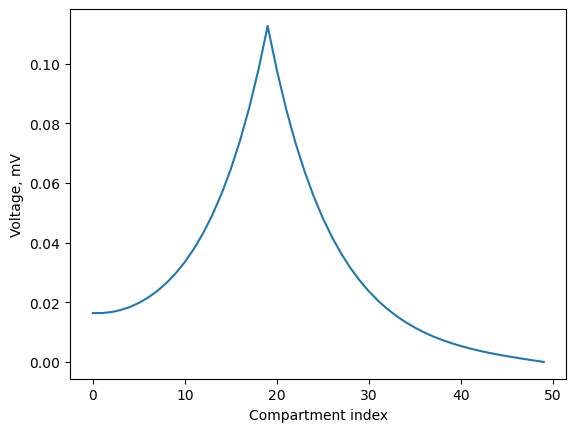

In [16]:
%matplotlib inline

plt.plot(np.arange(0, N), np.array(V)[:,-1] * 1000)
plt.xlabel('Compartment index')
plt.ylabel('Voltage, mV')
plt.show()

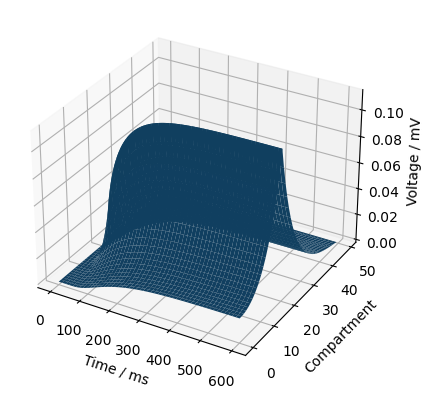

In [17]:

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
X, Y = np.meshgrid(range(N), time_axis * 1000)

ax.plot_surface(Y, X, np.array(V).T * 1000)
ax.set_xlabel('Time / ms')
ax.set_ylabel('Compartment')
ax.set_zlabel('Voltage / mV')
plt.show()

Since we have the model implemented, we can now also study the effect of a rectangular input current. We only need to implement the current function and then rerun our previous code. More precisely, consider the current input function
$$
I_e(t) = 
\begin{cases}
0, & (t < t_e) \vee (t_s \leq t) \vee (j\neq j_e) \\
I_1, & (t_e \leq t < t_s) \wedge (j = j_e)
\end{cases}.
$$

**Step 8:** Completing the function rectangle_input() to implement the rectangular input for $t_e = 0.02$ and $t_s = 0.4$.

In [18]:
def rectangle_input(time, N, input_compartment, I_1):
    '''Implements the rectangle-input function.

    Args:
        t: Time in seconds
        N: Number of compartments in the model
        input_compartment: Compartment in which the current is injected
        I_1: The value of the input current

    Returns:
        The input current at a given time as a np.array of length N
    '''

    if time <= t_e or time >= t_s or compartment_index != input_compartment:
        I_e = 0
    elif t_e <= time <= t_s and compartment_index == input_compartment:
        I_e = I_1
    return (I_e)

**Step 9:** Runnin the Euler approximation for the rectangular input with $I_1 = 100pA$. Plot the result in a 3D plot over space and time.

In [19]:
V = [np.zeros(1) for _ in range(N)]
for time in time_axis[1:len(time_axis)]:

    for compartment_index in range(1, N - 1):
        V = surrounded_compartment_step(V, rectangle_input(time, N, input_compartment, I_1), compartment_index, E_m, C_m,
                                        R_m, R_a, delta_t)

    for compartment_index in range(1):
        V = sealed_compartment_step(V, rectangle_input(time, N, input_compartment, I_1), E_m, C_m, R_m, R_a, delta_t,
                                    compartment_index)

    for compartment_index in range(N - 1, N - 2, -1):
        V = killed_compartment_step(V, rectangle_input(time, N, input_compartment, I_1), E_m, C_m, R_m, R_a, delta_t,
                                    compartment_index)

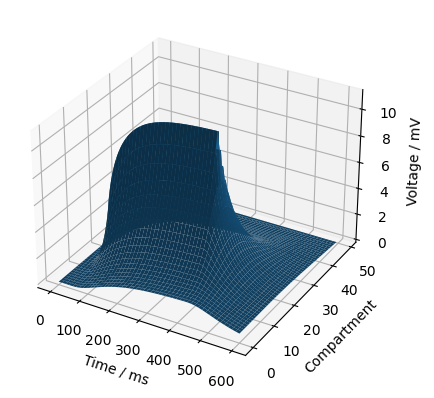

In [20]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
X, Y = np.meshgrid(range(N), time_axis * 1000)

ax.plot_surface(Y, X, np.array(V).T * 1000)
ax.set_xlabel('Time / ms')
ax.set_ylabel('Compartment')
ax.set_zlabel('Voltage / mV')
plt.show()